# Object Detection using YOLOv3

In this module, we will learn how to use YOLOv3 — a state of the art object detector — with OpenCV.

YOLOv3 is the latest variant of a popular object detection algorithm **YOLO – You Only Look Once**. The published model recognizes 80 different objects in images and videos, but most importantly it is super fast and nearly as accurate as Single Shot MultiBox (SSD).

## Why use OpenCV for YOLO ?
Here are a few reasons you may want to use OpenCV for YOLO

1. **Easy integration with an OpenCV application:** If your application already uses OpenCV and you simply want to use YOLOv3, you don’t have to worry about compiling and building the extra Darknet code.
2. **OpenCV CPU version is 9x faster:** OpenCV’s CPU implementation of the DNN module is astonishingly fast. For example, Darknet when used with OpenMP takes about 2 seconds on a CPU for inference on a single image. In contrast, OpenCV’s implementation runs in a mere 0.22 seconds! Check out table below.
3. **Python support:** Darknet is written in C, and it does not officially support Python. In contrast, OpenCV does. There are python ports available for Darknet though.

### Speed Test for YOLOv3 on Darknet and OpenCV
The following table shows the performance of YOLOv3 on Darknet vs. OpenCV. The input size in all cases is 416×416. It is not surprising the GPU version of Darknet outperforms everything else. It is also not suprising that Darknet with OpenMP works much better than Darknet without OpenMP because OpenMP enables use of multiple processors.

What is indeed surprising is that OpenCV’s CPU implementation of DNN is 9x faster than Darknet with OpenML.



| OS | Framework | CPU/GPU |Time(ms)/Frame|
| -------- | -------- | -------- |--|
| Linux 16.04    |Darknet     | 12x Intel Core i7-6850K CPU @ 3.60GHz     |9370|
|Linux 16.04|Darknet + OpenMP|12x Intel Core i7-6850K CPU @ 3.60GHz|1942|
|Linux 16.04|OpenCV [CPU]|12x Intel Core i7-6850K CPU @ 3.60GHz|220|
|Linux 16.04|Darknet|NVIDIA GeForce 1080 Ti GPU|23|	
|macOS|DarkNet|2.5 GHz Intel Core i7 CPU|7260|
|macOS|OpenCV [CPU]|2.5 GHz Intel Core i7 CPU|400|
			
<center>Table 1: Speed Test of YOLOv3 on Darknet vs OpenCV</center>

&nbsp;
**Note:** We ran into problems using OpenCV’s GPU implementation of the DNN. The documentation indicates that it is tested only with Intel’s GPUs, so the code would switch you back to CPU, if you do not have an Intel GPU.

## Object Detection using YOLOv3 in OpenCV
Let us now see how to use YOLOv3 in OpenCV to perform object detection.

In [23]:
import numpy as np
import cv2
import sys
import os.path
import matplotlib.pyplot as plt
from dataPath import DATA_PATH
from dataPath import MODEL_PATH
%matplotlib inline

In [24]:
import matplotlib
matplotlib.rcParams['figure.figsize'] = (15.0,15.0)
matplotlib.rcParams['image.cmap'] = 'gray'

## Step 1 : Initialize the parameters
The YOLOv3 algorithm generates bounding boxes as the predicted detection outputs. Every predicted box is associated with a confidence score. In the first stage, all the boxes below the confidence threshold parameter are ignored for further processing.

The rest of the boxes undergo non-maximum suppression which removes redundant overlapping bounding boxes. **Non-maximum suppression** is controlled by a parameter **nmsThreshold**. You can try to change these values and see how the number of output predicted boxes changes.

Next, the default values for the input width (**inpWidth**) and height (**inpHeight**) for the network’s input image are set. We set each of them to 416, so that we can compare our runs to the Darknet’s C code given by YOLOv3’s authors. You can also change both of them to 320 to get faster results or to 608 to get more accurate results.


In [25]:
# Initialize the parameters
objectnessThreshold = 0.5 # Objectness threshold
confThreshold = 0.5       # Confidence threshold
nmsThreshold = 0.4        # Non-maximum suppression threshold
inpWidth = 416            # Width of network's input image
inpHeight = 416           # Height of network's input image

## Step 2 : Load the model and classes
The file **coco.names** contains all the objects for which the model was trained. We read class names.

Next, we load the network which has two parts —

- **yolov3.weights :** The pre-trained weights.
- **yolov3.cfg :** The configuration file.

We set the DNN backend to OpenCV here and the target to CPU. You could try setting the preferable target to **cv.dnn.DNN_TARGET_OPENCL** to run it on a GPU. But keep in mind that the current OpenCV version is tested only with Intel’s GPUs, it would automatically switch to CPU, if you do not have an Intel GPU.

In [26]:
# Load names of classes
classesFile = MODEL_PATH + "coco.names"
classes = None
with open(classesFile, 'rt') as f:
    classes = f.read().rstrip('\n').split('\n')

# Give the configuration and weight files for the model and load the network using them.
modelConfiguration = MODEL_PATH + "yolov3.cfg"
modelWeights = MODEL_PATH + "yolov3.weights"

net = cv2.dnn.readNetFromDarknet(modelConfiguration, modelWeights)

## Step 3 : Process each frame
The input image is passed through the network and the output is decoded and displayed using a few utility functions. Let us go over the utility functions.

### Step 3a : Getting the names of output layers
The **forward** function in OpenCV’s Net class needs the ending layer till which it should run in the network. Since we want to run through the whole network, we need to identify the last layer of the network. We do that by using the function **getUnconnectedOutLayers()** that gives the names of the unconnected output layers, which are essentially the last layers of the network. Then we run the forward pass of the network to get output from the output layers, as in the previous code snippet (**net.forward(getOutputsNames(net))**).


In [27]:
# Get the names of the output layers
def getOutputsNames(net):
    # Get the names of all the layers in the network
    layersNames = net.getLayerNames()
    # Get the names of the output layers, i.e. the layers with unconnected outputs
    return [layersNames[i[0] - 1] for i in net.getUnconnectedOutLayers()]

### Step 3b : Draw the predicted boxes
This is a utility function which draws bounding boxes after the detected objects have been filtered through Non-Max suppression as discussed below.

In [28]:
# Draw the predicted bounding box
def drawPred(classId, conf, left, top, right, bottom):
    # Draw a bounding box.
    cv2.rectangle(frame, (left, top), (right, bottom), (255, 178, 50), 3)
    
    label = '%.2f' % conf
        
    # Get the label for the class name and its confidence
    if classes:
        assert(classId < len(classes))
        label = '%s:%s' % (classes[classId], label)

    #Display the label at the top of the bounding box
    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
    top = max(top, labelSize[1])
    cv2.rectangle(frame, (left, top - round(1.5*labelSize[1])), (left + round(1.5*labelSize[0]), top + baseLine), (255, 255, 255), cv2.FILLED)
    cv2.putText(frame, label, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0,0,0), 1)

### Step 3c : Post-processing the network’s output
The network outputs bounding boxes are each represented by a vector of number of classes + 5 elements.

The first 4 elements represent the **center_x**, **center_y**, **width** and **height**. The fifth element represents the confidence that the bounding box encloses an object.

The rest of the elements are the confidence associated with each class (i.e. object type). The box is assigned to the class corresponding to the highest score for the box.

The highest score for a box is also called its **confidence**. If the confidence of a box is less than the given threshold, the bounding box is dropped and not considered for further processing.

The boxes with their confidence equal to or greater than the confidence threshold are then subjected to Non Maximum Suppression. This would reduce the number of overlapping boxes.


In [33]:
# Remove the bounding boxes with low confidence using non-maxima suppression
def postprocess(frame, outs):
    frameHeight = frame.shape[0]
    frameWidth = frame.shape[1]

    classIds = []
    confidences = []
    boxes = []
    # Scan through all the bounding boxes output from the network and keep only the
    # ones with high confidence scores. Assign the box's class label as the class with the highest score.
    classIds = []
    confidences = []
    boxes = []
    for out in outs:
        for detection in out:
            if detection[4] > objectnessThreshold :
                scores = detection[5:]
                classId = np.argmax(scores)
                confidence = scores[classId]
                if confidence > confThreshold:
                    center_x = int(detection[0] * frameWidth)
                    center_y = int(detection[1] * frameHeight)
                    width = int(detection[2] * frameWidth)
                    height = int(detection[3] * frameHeight)
                    left = int(center_x - width / 2)
                    top = int(center_y - height / 2)
                    classIds.append(classId)
                    confidences.append(float(confidence))
                    boxes.append([left, top, width, height])

    # Perform non maximum suppression to eliminate redundant overlapping boxes with
    # lower confidences.
    indices = cv2.dnn.NMSBoxes(boxes, confidences, confThreshold, nmsThreshold)
    for i in indices:
        i = i[0]
        box = boxes[i]
        left = box[0]
        top = box[1]
        width = box[2]
        height = box[3]
        drawPred(classIds[i], confidences[i], left, top, left + width, top + height)

The Non Maximum Suppression is controlled by the nmsThreshold parameter. If nmsThreshold is set too low, e.g. 0.1, we might not detect overlapping objects of same or different classes. But if it is set too high e.g. 1, then we get multiple boxes for the same object. So we used an intermediate value of 0.4 in our code above. The gif below shows the effect of varying the NMS threshold.

<center><a href="https://www.learnopencv.com/wp-content/uploads/2018/08/nms-threshold-object-detection.gif"><img src="https://www.learnopencv.com/wp-content/uploads/2018/08/nms-threshold-object-detection.gif"/> </a></center>

<center>non maximum suppression threshold object detection</center>

## The main loop
The input image to a neural network needs to be in a certain format called a **blob**.

After a frame is read from the input image or video stream, it is passed through the **blobFromImage** function to convert it to an **input blob** for the neural network. In this process, it scales the image pixel values to a target range of 0 to 1 using a scale factor of 1/255. It also resizes the image to the given size of (416, 416) without cropping. Note that we do not perform any mean subtraction here, hence pass [0,0,0] to the mean parameter of the function and keep the swapRB parameter to its default value of 1.

The output blob is then passed in to the network as its input and a forward pass is run to get a list of predicted bounding boxes as the network’s output. These boxes go through a post-processing step in order to filter out the ones with low confidence scores. We will go through the post-processing step in more detail in the next section. We print out the inference time for each frame at the top left. The image with the final bounding boxes is then saved to the disk, either as an image for an image input or using a video writer for the input video stream.


3


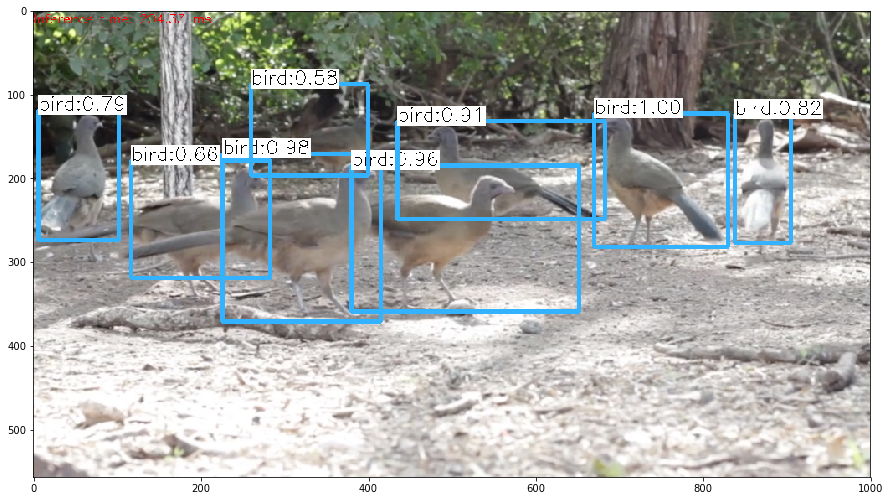

Inference time: 204.33 ms


In [32]:
# Process inputs
imagePath = DATA_PATH + "images/bird.jpg"
frame = cv2.imread(imagePath)


# Create a 4D blob from a frame.
blob = cv2.dnn.blobFromImage(frame, 1/255, (inpWidth, inpHeight), [0,0,0], 1, crop=False)

# Sets the input to the network
net.setInput(blob)

# Runs the forward pass to get output of the output layers
outs = net.forward(getOutputsNames(net))
#outs = net.forward()


# Remove the bounding boxes with low confidence
postprocess(frame, outs)

# Put efficiency information. The function getPerfProfile returns the overall time for inference(t) and the timings for each of the layers(in layersTimes)
t, _ = net.getPerfProfile()
label = 'Inference time: %.2f ms' % (t * 1000.0 / cv2.getTickFrequency())
cv2.putText(frame, label, (0, 15), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255))

plt.imshow(frame[...,::-1])
plt.show()
print(label)